## _Trading Strategy using Actor Critic RL_

In [7]:
# import libraries

import math, random
import gym
import numpy as np
import pandas as pd
import quandl
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
torch.manual_seed(51)

## _Use Quandl API to get stock data of companies of interest_

In [10]:
apl_stock=quandl.get('WIKI/AAPL', start_date="2014-01-01", end_date="2018-09-12", )
ge_stock=quandl.get('WIKI/GE', start_date="2014-01-01", end_date="2018-09-12")
apl_open = apl_stock["Open"].values
apl_close = apl_stock["Close"].values
ge_open = ge_stock["Open"].values
ge_close = ge_stock["Close"].values
apl_stock['Date'] = apl_stock.index.strftime('%Y-%m-%d')
ge_stock['Date'] = ge_stock.index.strftime('%Y-%m-%d')

## _Read in Time Series and DL Predictions_

In [11]:
apl_preds_lstm = pd.read_csv('apple_predictions_train.csv')
apl_preds_lstm = apl_preds_lstm[(apl_preds_lstm.Date >= '2014-01-01') & (apl_preds_lstm.Date <= '2019-09-12')]
ge_preds_lstm = pd.read_csv('ge_predictions_train.csv')
ge_preds_lstm = ge_preds_lstm[(ge_preds_lstm.Date >= '2014-01-01') & (ge_preds_lstm.Date <= '2019-09-12')]

In [12]:
nlp_state_rl = pd.read_csv('rl_8k_state.csv')

nlp_state_rl.index = nlp_state_rl.Date

nlp_state_rl = nlp_state_rl.drop(['Date'], axis = 1)

In [13]:
apl_preds_lstm.head()

,Unnamed: 0,Date,predictions,ticker
4019,2014-01-02,2014-01-02,78.488525,Apple Inc.
4020,2014-01-03,2014-01-03,79.466225,Apple Inc.
4021,2014-01-06,2014-01-06,78.303370,Apple Inc.
4022,2014-01-07,2014-01-07,76.310740,Apple Inc.
4023,2014-01-08,2014-01-08,77.010540,Apple Inc.


In [14]:
apl_stock.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Date
Date,,,,,,,,,,,,,
2014-01-02,555.68,557.03,552.021,553.1300,8381600.0,0.0,1.0,73.862376,74.041821,73.376012,73.523423,58671200.0,2014-01-02
2014-01-03,552.86,553.70,540.430,540.9800,14016700.0,0.0,1.0,73.487534,73.599189,71.835308,71.908415,98116900.0,2014-01-03
2014-01-06,537.45,546.80,533.600,543.9300,14736100.0,0.0,1.0,71.439198,72.682024,70.927447,72.300536,103152700.0,2014-01-06
2014-01-07,544.32,545.96,537.925,540.0375,11328900.0,0.0,1.0,72.352376,72.570369,71.502337,71.783135,79302300.0,2014-01-07
2014-01-08,538.81,545.56,538.690,543.4600,9233200.0,0.0,1.0,71.619973,72.517200,71.604022,72.238063,64632400.0,2014-01-08


In [16]:
apl_stock = pd.merge(apl_stock, apl_preds_lstm[['Date', 'predictions']], how='left', on = 'Date')

apl_stock = pd.merge(apl_stock, nlp_state_rl[['AppleDown', 'AppleStay', 'AppleUp']], how='left', on='Date')

C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
ge_preds_lstm.head()

,Unnamed: 0,Date,predictions,ticker
4019,2014-01-02,2014-01-02,22.785814,GE
4020,2014-01-03,2014-01-03,22.889317,GE
4021,2014-01-06,2014-01-06,22.570192,GE
4022,2014-01-07,2014-01-07,22.481403,GE
4023,2014-01-08,2014-01-08,22.333170,GE


In [18]:
ge_stock = pd.merge(ge_stock, ge_preds_lstm[['Date', 'predictions']], how='left', on = 'Date')

ge_stock = pd.merge(ge_stock, nlp_state_rl[['GeDown', 'GeStay', 'GeUp']], how='left', on = 'Date')

C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
ge_stock.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Date,predictions,GeDown,GeStay,GeUp
0,27.86,27.940,27.41,27.50,41453700.0,0.0,1.0,24.583666,24.654258,24.186586,24.266002,41453700.0,2014-01-02,22.785814,0.0,0.0,0.0
1,27.52,27.600,27.41,27.48,27570800.0,0.0,1.0,24.283650,24.354242,24.186586,24.248354,27570800.0,2014-01-03,22.889317,0.0,0.0,0.0
2,27.66,27.725,27.15,27.26,29356600.0,0.0,1.0,24.407186,24.464542,23.957162,24.054226,29356600.0,2014-01-06,22.570192,0.0,0.0,0.0
3,27.48,27.490,27.21,27.29,24728000.0,0.0,1.0,24.248354,24.257178,24.010106,24.080698,24728000.0,2014-01-07,22.481403,0.0,0.0,0.0
4,27.35,27.360,27.12,27.21,25868900.0,0.0,1.0,24.133642,24.142466,23.930690,24.010106,25868900.0,2014-01-08,22.333170,0.0,0.0,0.0


In [25]:
from scipy import signal

In [26]:
msf_open = signal.detrend(ge_open)
msf_close = signal.detrend(ge_close)

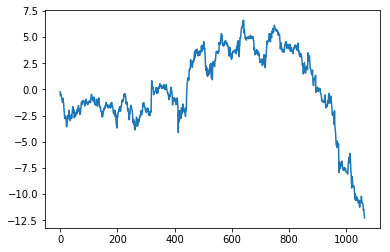

In [27]:
plt.plot(range(0,len(ge_open)), msf_oge_openpen)

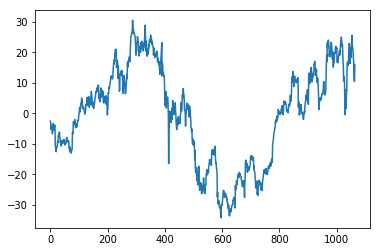

In [28]:
apl_open = signal.detrend(apl_open)
apl_close = signal.detrend(apl_close)
plt.plot(range(0, len(apl_open)), apl_open)

In [29]:
print(apl_open.min())
print(apl_close.min())
print(msf_open.min())
print(msf_close.min())

-34.32168425572118
-34.447411978136344
-12.275226243514874
-12.289489806781177


Choose 35

In [30]:
apl_open += 35.
apl_close += 35.
msf_open += 35.
msf_close += 35.

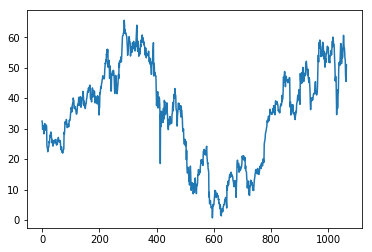

In [33]:
plt.plot(range(0,len(apl_open)), apl_open)

# Build the environment

In [34]:
class TradingEnvironment():
    
    def __init__(self, starting_cash_mean=200., max_stride=5, series_length=208, starting_point=1, randomize_cash_std=0, \
                 starting_shares_mean=0., randomize_shares_std=0., inaction_penalty=0.):
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(16)).cuda()
        
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.starting_portfolio_value = self.portfolio_value()
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = ge_open[self.cur_timestep]
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]
        self.state[8] = apl_stock.predictions.values[self.cur_timestep + 1]
        self.state[9] = ge_stock.predictions.values[self.cur_timestep + 1]
        self.state[10] = apl_stock.AppleStay.values[self.cur_timestep]
        self.state[11] = apl_stock.AppleUp.values[self.cur_timestep]
        self.state[12] = ge_stock.predictions.values[self.cur_timestep]
        self.state[13] = ge_stock.GeDown.values[self.cur_timestep]
        self.state[14] = ge_stock.GeStay.values[self.cur_timestep]
        self.state[15] = ge_stock.GeUp.values[self.cur_timestep]
        
        self.max_stride = max_stride
        self.stride = self.max_stride # no longer varying it
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty

    def portfolio_value(self):
        return (self.state[0] * apl_close[self.cur_timestep]) + (self.state[1] * ge_close[self.cur_timestep]) + self.state[2]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [apl_open[step], ge_open[step]]
    
    def next_predictions(self):
        step = self.cur_timestep + self.stride
        if step < len(apl_stock.predictions.values):
            return [apl_stock.predictions.values[step + 1], apl_stock.AppleDown.values[step + 1],
                apl_stock.AppleStay.values[step], apl_stock.AppleUp.values[step],
                ge_stock.predictions.values[step], ge_stock.GeDown.values[step],
                ge_stock.GeStay.values[step], ge_stock.GeUp.values[step]
               ]
        return [apl_stock.predictions.values[step], apl_stock.AppleDown.values[step],
                apl_stock.AppleStay.values[step], apl_stock.AppleUp.values[step],
                ge_stock.predictions.values[step], ge_stock.GeDown.values[step],
                ge_stock.GeStay.values[step], ge_stock.GeUp.values[step]
               ]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return [apl_open[0], msf_open[0]]
        apl5 = apl_open[step-5:step].mean()
        ge5 = ge_open[step-5:step].mean()
        return [apl5,ge5]
    
    def step(self, action):
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window(), *self.next_predictions()]
            self.state = new_state
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.diversification_bonus
            return new_state, cur_value + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                    cur_value, *self.five_day_window(), *self.next_predictions()]
            self.state = new_state
            retval = new_state, -self.inaction_penalty - ts_left + gain, False, { "msg": "nothing" }
            
        if action[0] == 0:
            if action[1] * apl_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window(), *self.next_predictions()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                apl_shares = self.state[0] + action[1]
                cash_spent = action[1] * apl_open[cur_timestep] * 1.1
                new_state = [apl_shares, self.state[1], self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window(), *self.next_predictions()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought AAPL"}
                
        if action[0] == 3:
            if action[1] * msf_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window(), *self.next_predictions()]
                self.state = new_state
                retval =  new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                msf_shares = self.state[1] + action[1]
                cash_spent = action[1] * msf_open[cur_timestep] * 1.1
                new_state = [self.state[0], msf_shares, self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window(), *self.next_predictions()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought GE"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window(), *self.next_predictions()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                apl_shares = self.state[0] - action[1]
                cash_gained = action[1] * apl_open[cur_timestep] * 0.9
                new_state = [apl_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window(), *self.next_predictions()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window(), *self.next_predictions()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                msf_shares = self.state[1] - action[1]
                cash_gained = action[1] * msf_open[cur_timestep] * 0.9
                new_state = [self.state[0], msf_shares, self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window(), *self.next_predictions()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold GE"}
                
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(16)).cuda()
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = ge_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]
        self.state[8] = apl_stock.predictions.values[self.cur_timestep + 1]
        self.state[9] = ge_stock.predictions.values[self.cur_timestep + 1]
        self.state[10] = apl_stock.AppleStay.values[self.cur_timestep]
        self.state[11] = apl_stock.AppleUp.values[self.cur_timestep]
        self.state[12] = ge_stock.predictions.values[self.cur_timestep]
        self.state[13] = ge_stock.GeDown.values[self.cur_timestep]
        self.state[14] = ge_stock.GeStay.values[self.cur_timestep]
        self.state[15] = ge_stock.GeUp.values[self.cur_timestep]
        self.done = False
        return self.state

In [35]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(16, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 5)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        
    def forward(self, x):
        x = torch.tensor(x).cuda()
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [36]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
model = Policy().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [37]:
env.reset()
# In case you're running this a second time with the same model, delete the gradients
del model.rewards[:]
del model.saved_actions[:]

gamma = 0.9
log_interval = 60

def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    # With different architectures, I found the following standardization step sometimes
    # helpful, sometimes unhelpful.
    # rewards = (rewards - rewards.mean()) / (rewards.std(unbiased=False) + epsilon)
    # Alternatively, comment it out and use the following line instead:
    rewards += epsilon
    
    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = torch.tensor(r - value.item()).cuda()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).cuda()))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

running_reward = 0
for episode in range(0, 4000):
    state = env.reset()
    reward = 0
    done = False
    msg = None
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.4 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))

C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 7500.2, finished at 8536.7 because done @ t=1001, last reward 9574.2, running reward 159.6
Episode 60: started at 6832.9, finished at 8353.7 because done @ t=1001, last reward 9875.5, running reward 2861.7
Episode 120: started at 7698.6, finished at 8844.9 because bankrupted self @ t=817, last reward 968.6, running reward 4461.6
Episode 180: started at 7596.0, finished at 8140.2 because bankrupted self @ t=457, last reward 364.1, running reward 4816.4
Episode 240: started at 7380.9, finished at 5217.4 because bankrupted self @ t=529, last reward -700.8, running reward 5536.8
Episode 300: started at 6971.5, finished at 7366.6 because done @ t=1001, last reward 7762.6, running reward 4710.4
Episode 360: started at 7599.0, finished at 8727.9 because bankrupted self @ t=925, last reward 1301.3, running reward 5130.8


KeyboardInterrupt: 

In [41]:
import hiddenlayer as hl

h1 = hl.build_graph(model, torch.zeros([1, 16]))

h1.save('rl_model.png', format='png')

C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

(dot.exe:20816): Pango-WARNING **: couldn't load font "Times Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


## Check on Train Data

In [42]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)

total_rewards = 0
total_profits = 0
failed_goes = 0
num_goes = 50

for j in range(num_goes):
    env.reset()
    reward_this_go = -1e8
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == "done":
            reward_this_go = env.portfolio_value()
            break
        if done:
            break
    total_profits += (env.portfolio_value() - env.starting_portfolio_value) / env.starting_portfolio_value
    if reward_this_go == -1e8:
        failed_goes += 1
    else:
        total_rewards += reward_this_go

if failed_goes == num_goes:
    print("Failed all")
else:
    print("Failed goes: {} / {}, Avg Rewards per successful game: {}".format(failed_goes, num_goes, total_rewards / (num_goes - failed_goes)))
    print("Avg % profit per game: {}".format(total_profits / num_goes))
    print("Avg % profit per finished game: {}".format(total_profits / (num_goes - failed_goes)))

C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Failed goes: 20 / 50, Avg Rewards per successful game: 8421.6708984375
Avg % profit per game: 0.08653195947408676
Avg % profit per finished game: 0.14421994984149933


## _Sample Run_

In [43]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} aapl and {} GE and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
    if msg["msg"] == "done":
        print(next_state, reward)
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 7802.861328125
sold AAPL, have 114.0 aapl and 97.0 GE and 1008.7981567382812 cash
nothing, have 114.0 aapl and 97.0 GE and 1008.7981567382812 cash
bought AAPL, have 115.0 aapl and 97.0 GE and 974.1239624023438 cash
sold AAPL, have 114.0 aapl and 97.0 GE and 1001.9021606445312 cash
bought GE, have 114.0 aapl and 98.0 GE and 966.3832397460938 cash
sold AAPL, have 113.0 aapl and 98.0 GE and 987.4376831054688 cash
bought AAPL, have 114.0 aapl and 98.0 GE and 959.0685424804688 cash
bought AAPL, have 115.0 aapl and 98.0 GE and 928.9262084960938 cash
sold AAPL, have 114.0 aapl and 98.0 GE and 953.1168212890625 cash
nothing, have 114.0 aapl and 98.0 GE and 953.1168212890625 cash
nothing, have 114.0 aapl and 98.0 GE and 953.1168212890625 cash
bought AAPL, have 115.0 aapl and 98.0 GE and 925.218994140625 cash
sold AAPL, have 114.0 aapl and 98.0 GE and 947.8432006835938 cash
nothing, have 114.0 aapl and 98.0 GE and 947.8432006835938 cash
sold GE, have 114.0 aapl and 97.0 

C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


nothing, have 114.0 aapl and 95.0 GE and 1003.8015747070312 cash
nothing, have 114.0 aapl and 95.0 GE and 1003.8015747070312 cash
bought AAPL, have 115.0 aapl and 95.0 GE and 959.9237670898438 cash
sold GE, have 115.0 aapl and 94.0 GE and 989.4777221679688 cash
sold AAPL, have 114.0 aapl and 94.0 GE and 1022.9745483398438 cash
sold AAPL, have 113.0 aapl and 94.0 GE and 1057.375732421875 cash
nothing, have 113.0 aapl and 94.0 GE and 1057.375732421875 cash
bought GE, have 113.0 aapl and 95.0 GE and 1020.3154296875 cash
sold GE, have 113.0 aapl and 94.0 GE and 1050.3682861328125 cash
bought GE, have 113.0 aapl and 95.0 GE and 1013.6690673828125 cash
nothing, have 113.0 aapl and 95.0 GE and 1013.6690673828125 cash
sold GE, have 113.0 aapl and 94.0 GE and 1043.65234375 cash
bought AAPL, have 114.0 aapl and 94.0 GE and 997.4658203125 cash
nothing, have 114.0 aapl and 94.0 GE and 997.4658203125 cash
sold GE, have 114.0 aapl and 93.0 GE and 1026.8214111328125 cash
nothing, have 114.0 aapl and 

bought GE, have 105.0 aapl and 97.0 GE and 1141.43896484375 cash
bought AAPL, have 106.0 aapl and 97.0 GE and 1119.342529296875 cash
bought GE, have 106.0 aapl and 98.0 GE and 1077.7843017578125 cash
sold AAPL, have 105.0 aapl and 98.0 GE and 1092.1099853515625 cash
sold GE, have 105.0 aapl and 97.0 GE and 1125.4837646484375 cash
nothing, have 105.0 aapl and 97.0 GE and 1125.4837646484375 cash
sold AAPL, have 104.0 aapl and 97.0 GE and 1132.78466796875 cash
bought GE, have 104.0 aapl and 98.0 GE and 1088.9776611328125 cash
bought GE, have 104.0 aapl and 99.0 GE and 1044.773681640625 cash
bought AAPL, have 105.0 aapl and 99.0 GE and 1033.1612548828125 cash
nothing, have 105.0 aapl and 99.0 GE and 1033.1612548828125 cash
sold AAPL, have 104.0 aapl and 99.0 GE and 1046.9910888671875 cash
bought GE, have 104.0 aapl and 100.0 GE and 1001.727294921875 cash
sold AAPL, have 103.0 aapl and 100.0 GE and 1016.9699096679688 cash
sold AAPL, have 102.0 aapl and 100.0 GE and 1030.452880859375 cash
bo

In [44]:
apl_open_orig_ = apl_stock["Open"].values
apl_close_orig_ = apl_stock["Close"].values
apl_open_orig = apl_stock["Open"].values
apl_close_orig = apl_stock["Close"].values
msf_open_orig = msf_stock["Open"].values
msf_close_orig = msf_stock["Close"].values
apl_open_orig[:108] /= 7
apl_close_orig[:108] /= 7

In [45]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
complete_game = False
while not complete_game:
    bought_apl_at = []
    bought_msf_at = []
    sold_apl_at = []
    sold_msf_at = []
    bought_apl_at_orig = []
    bought_msf_at_orig = []
    sold_apl_at_orig = []
    sold_msf_at_orig = []
    nothing_at = []
    ba_action_times = []
    bm_action_times = []
    sa_action_times = []
    sm_action_times = []
    n_action_times = []
    starting_val = env.starting_portfolio_value
    print("Starting portfolio value: {}".format(starting_val))
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        if action == 0:
            bought_apl_at.append(apl_open[env.cur_timestep])
            bought_apl_at_orig.append(apl_open_orig[env.cur_timestep])
            ba_action_times.append(env.cur_timestep)
        if action == 1:
            sold_apl_at.append(apl_close[env.cur_timestep])
            sold_apl_at_orig.append(apl_close_orig[env.cur_timestep])
            sa_action_times.append(env.cur_timestep)
        if action == 2:
            nothing_at.append(35)
            n_action_times.append(env.cur_timestep)
        if action == 3:
            bought_msf_at.append(msf_open[env.cur_timestep])
            bought_msf_at_orig.append(msf_open_orig[env.cur_timestep])
            bm_action_times.append(env.cur_timestep)
        if action == 4:
            sold_msf_at.append(msf_close[env.cur_timestep])
            sold_msf_at_orig.append(msf_close_orig[env.cur_timestep])
            sm_action_times.append(env.cur_timestep)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == 'bankrupted self':
            env.reset()
            break
        if msg["msg"] == 'sold more than have':
            env.reset()
            break
        if msg["msg"] == "done":
            print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
            val = env.portfolio_value()
            print("Finished portfolio value {}".format(val))
            if val > starting_val * 1.1: complete_game = True
            env.reset()
            break

Starting portfolio value: 7039.4599609375


C:\Users\Sri Yogesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Starting portfolio value: 7399.1171875
Starting portfolio value: 7314.4384765625
done, have 103.0 aapl and 83.0 msft and 705.3350830078125 cash
Finished portfolio value 8340.8515625


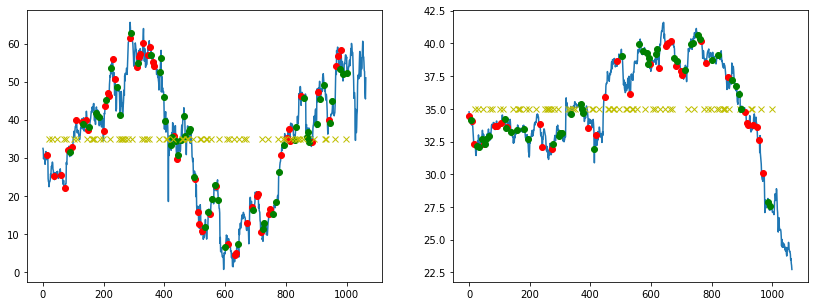

In [46]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open)), apl_open)
msf.plot(range(0, len(msf_open)), msf_open)
apl.plot(ba_action_times, bought_apl_at, "ro")
apl.plot(sa_action_times, sold_apl_at, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at, "ro")
msf.plot(sm_action_times, sold_msf_at, "go")

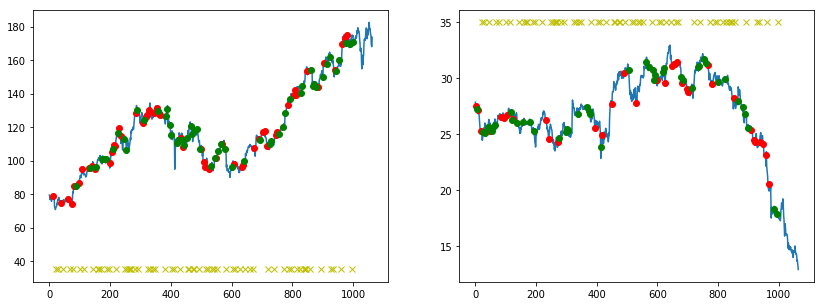

In [47]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open_orig)), apl_open_orig)
msf.plot(range(0, len(msf_open_orig)), msf_open_orig)
apl.plot(ba_action_times, bought_apl_at_orig, "ro")
apl.plot(sa_action_times, sold_apl_at_orig, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at_orig, "ro")
msf.plot(sm_action_times, sold_msf_at_orig, "go")